# Metrics

Implement metrics to evaluate clustering performance based on BCubed precision and recall [1].

From the original paper, layercluster is analog to image, trackster to cluster, and subject to simtrackster:

$$
P_b = \frac{1}{N} \sum_{i=1}^{N} \frac{1}{|T(i)|} \sum_{j \in T(i)}B(i, j)
$$

$$
R_b = \frac{1}{N} \sum_{i=1}^{N} \frac{1}{|L(i)|} \sum_{j \in L(i)}B(i, j)
$$

Where $T(i)$ is the trackster that contains layercluster $i$, and $L(i)$ are all layerclusters of the same simtrackster as layercluster $i$.

$B(i,j)$ is:
- 1 if a pair of layerclusters $(i, j)$ of the same simtrackster are in the same trackster
- 0 otherwise

Then the F-score is computed as:
$$
F_p = \frac{2P_bR_b}{P_b + R_b}
$$

## Multiple layerclusters per trackster

Each layer-cluster can be a part of multiple tracksters / simtracksters.

$$
P_b = \frac{1}{N} \sum_{i=1}^{N} \frac{1}{|T(i)|} \sum_{t \in T(i)} \frac{1}{|t|} \sum_{j \in t}B(i, j)
$$

Where $T(i)$ are the trackster**s** that contains layercluster $i$. $t$ is one of the tracksters that contain layercluster $i$.

$$
R_b = \frac{1}{N} \sum_{i=1}^{N} \frac{1}{|L(i)|} \sum_{l \in L(i)} \frac{1}{|l|} \sum_{j \in l}B(i, j)
$$

and $L(i)$ are all layerclusters of the same simtrackster**s** as layercluster $i$. $l$ are all layerclusters of one of the simtracksters that contain $i$.


$B(i,j)$ is:
- a fraction as tracksters the pair of layerclusters $(i, j)$ have in common
- 0 otherwise

## Energy-aware score

From TICL:
$$
multiplicity_{LC} = \frac{E_{LC}}{\sum_{LC}{{}_{hits}(fr_{hit}inSC * E_{hit})}}
$$

For each pair, multiply the score with the trackster energies:

$$
Pe_b = \frac{1}{N} \sum_{i=1}^{N} \frac{1}{|T(i)|} \sum_{t \in T(i)} \frac{1}{E(i, t)} \sum_{j \in t}B(i, j)E_t(i, j)
$$

Where $E(i, t)$ is the total energy of all trackster pairs between $i$ and $t$ and $E_t(i, j)$ is the layercluster pair energy of $i$ and $j$ in trackster $t$.

$$
Re_b = \frac{1}{N} \sum_{i=1}^{N} \frac{1}{|L(i)|} \sum_{l \in L(i)} \frac{1}{E(l)} \sum_{j \in l}B(i, j)E_l(i,j)
$$

$B(i,j)$ is:
- the intersection over union of layercluster energy fractions

[1] Amigó, E., Gonzalo, J., Artiles, J. et al. A comparison of extrinsic clustering evaluation metrics based on formal constraints. Inf Retrieval 12, 461–486 (2009). https://doi.org/10.1007/s10791-008-9066-8

In [12]:
import uproot
import awkward as ak
import numpy as np
from reco.plotting import plot_event
from reco.energy import get_total_energy, get_energy_map
from reco.evaluation import bcubed, f_score
from reco.event import get_trackster_map

# %matplotlib widget
%matplotlib inline

file_name = "~/data/close_by_two_photons/new_ntuples_14992861_331.root"
# file_name = "~/data/multiparticle/new_ntuples_14132277_842.root"
# file_name = "~/data/close_by_two_pions_15cm/new_ntuples_14955802_28.root"

tracksters = uproot.open({file_name: "ticlNtuplizer/tracksters"})
simtracksters = uproot.open({file_name: "ticlNtuplizer/simtrackstersSC"})
associations = uproot.open({file_name: "ticlNtuplizer/associations"})

# simtracksters.show(name_width=40)

Vertices in Tracksters and Simtracksters are in the same collection (with matching IDs).
- Not all vertices are present in the reconstruction

In [55]:
eid = 1
t_indexes = tracksters["vertices_indexes"].array()[eid]
t_energy = tracksters["vertices_energy"].array()[eid]
v_multi = tracksters["vertices_multiplicity"].array()[eid]
st_indexes = simtracksters["stsSC_vertices_indexes"].array()[eid]
st_energy = simtracksters["stsSC_vertices_energy"].array()[eid]
sv_multi = simtracksters["stsSC_vertices_multiplicity"].array()[eid]
t_vertices = np.array(list(set(list(ak.flatten(t_indexes)))))
st_vertices = ak.flatten(st_indexes)

# precompute LC -> Trackster mapping
i2rt = get_trackster_map(t_indexes, v_multi)
i2st = get_trackster_map(st_indexes, sv_multi, 0.5)

# precompute LC -> Energy mapping (same for all tracksters the LC is in)
te_map = get_energy_map(t_indexes, t_energy, v_multi)     
ste_map = get_energy_map(st_indexes, st_energy, sv_multi)

Simulated energy: 189.90, reconstructed energy: 178.08 (93.77%)
[N] Precision: 0.89, Recall: 0.53, F-score: 0.67
[E] Precision: 0.93, Recall: 0.91, F-score: 0.92


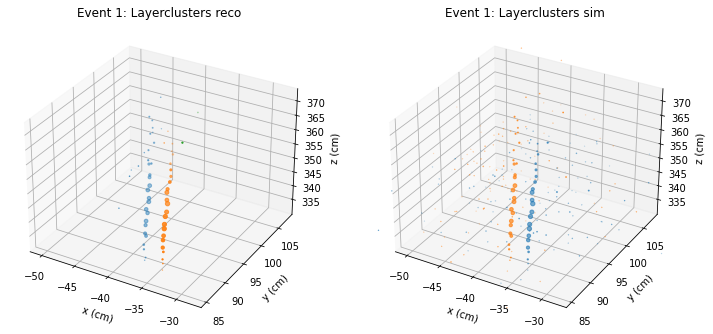

In [56]:
noise = False

reco_total = get_total_energy(t_energy, v_multi)
sim_total = get_total_energy(st_energy, sv_multi)
print(f"Simulated energy: {sim_total:.2f}, reconstructed energy: {reco_total:.2f} ({(reco_total / sim_total) * 100:.2f}%)")

# compute precision
precision = bcubed(t_vertices, t_indexes, i2rt, i2st)
precision_e = bcubed(t_vertices, t_indexes, i2rt, i2st, e_map=te_map)

# compute recall (with noise or without)
r_vertices = st_vertices if noise else t_vertices
recall = bcubed(r_vertices, st_indexes, i2st, i2rt)
recall_e = bcubed(r_vertices, st_indexes, i2st, i2rt, e_map=ste_map)

print(f"[N] Precision: {precision:.2f}, Recall: {recall:.2f}, F-score: {f_score(precision, recall):.2f}")
print(f"[E] Precision: {precision_e:.2f}, Recall: {recall_e:.2f}, F-score: {f_score(precision_e, recall_e):.2f}")
plot_event(tracksters, simtracksters, eid, legend=False)

In [4]:
# test B function
from reco.evaluation import B

In [5]:
mapping = {
    100: [(0, 0.6), (1, 0.4)],
    101: [(0, 0.8), (2, 0.2)]
}

B(100, 101, mapping)

0.7